
# ACH2016 - Inteligência Artificial

### Rubens Victor Gomes 8598878 <br> Higor 22222222 ### 

[Kmeans](#kmeans)<br>
Kmeans ++<br>
Small dataset pre processing<br>
Binary<br>
Tf-Df<br>
Tf-Idf<br>
Big dataset pre processing<br>
[Visualization of the clusters](#visualization)<br>
[Silhouette visualization](#visualization) <br>
Silhouette implementation<br>
Elbow Method<br>
IEEE Report<br>

In [59]:
#Importing the dependencies
import re, string, unicodedata, itertools, random, os, glob, math
import pickle

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

from __future__ import print_function
print(__doc__)

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (24, 9)
plt.style.use('ggplot')

Automatically created module for IPython interactive environment


In [60]:
# LOAD THE DATASET
print('reading...')
X = np.loadtxt('tfidf_matrix.txt')
print('loaded')
print(X.shape)
print(X[0])

reading...
loaded
(1000, 1195)
[0. 0. 0. ... 0. 0. 0.]


In [61]:
# Centroids initializations
# @method
# 'zeros' initialize with zeros
# 'random' pick k random datapoints
# 'k-means++' pick the first random, then pick k - 1 datapoints that maximizes the D² between them
def initializeCentroid(X, K, method = 'k-means',metric='euclidean'):
    centroids = []
    
    # maxime the squared distance of centroids
    # 1.Choose one center uniformly at random from among the data points.
    # 2.For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
    # 3.Choose one new data point at random as a new center, 
        #using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2.
    # 4.Repeat Steps 2 and 3 until k centers have been chosen.
    if method == 'k-means++':
        #primeiro centroide (aleatorio)
        centroids = np.zeros((K, X.shape[1]))
        centroids[0] = X[np.random.choice(X.shape[0], 1)]
        
        num_instances, num_features = X.shape
        
        #enquanto nao tiver K centroides
        for z in range(1,K):
            D2 = []
            prob = []
            cumprob = []
        
            #calcula matriz de distancia
            if metric == 'cosine_similarity':
                dist_matrix = 1 - pairwise_distances(X,centroids,metric = 'cosine')
            else:
                dist_matrix = pairwise_distances(X, centroids)
        
            for i in np.arange(num_instances):
                # finding the closest centroid
                d = dist_matrix[i]
                if metric == 'cosine_similarity':
                    D2.append((np.where(d == np.max(d)))[0][0])
                else:
                    D2.append((np.where(d == np.min(d)))[0][0])
        
            #faz a soma das probabilidades
            for i in np.arange(num_instances):
                prob.append(D2[i]/sum(D2))
        
            #gera a probabilidade acumulada e escolhe o centroide
            for i in np.arange(num_instances):
                somacum = 0
                for j in range(0,i):
                    somacum += prob[j]
                cumprob.append(somacum)
                
            rn = random.random()
            ind = 0
            for i in np.arange(num_instances):
                if(cumprob[i] >= rn):
                    ind = i
                    break
                
            #np.append(centroids,X[ind])
            centroids[z] = X[ind]
            
    if method == 'random':
        centroids = X[np.random.choice(X.shape[0], K)]
        
    return centroids

In [62]:
def kMeans(X, K, max_iterations=300, method='random',metric='euclidean'):

    num_instances, num_features = X.shape
    
    # Initialize the centroids
    # Pick k random points to use as our initial centroids
    centroids = initializeCentroid(X, K, method,metric)
    centroids_old = np.zeros(centroids.shape)
    
    iterations = 0
    clusters = np.random.choice(np.arange(K), num_instances)
    while (centroids_old != centroids).any() and iterations<max_iterations:
        # make the new centroids the current
        centroids_old = centroids.copy()
        
        # distance_matrix p=2 normal form
        if metric == 'cosine_similarity':
            dist_matrix = 1-pairwise_distances(X,centroids,metric='cosine')
        else:
            dist_matrix = pairwise_distances(X, centroids)
        iterations += 1
        for i in np.arange(num_instances):
            # finding the closest centroid
            d = dist_matrix[i]
            if metric == 'cosine_similarity':
                closest_centroid = (np.where(d == np.max(d)))[0][0]
            else:
                closest_centroid = (np.where(d == np.min(d)))[0][0]
            
            # each datapoint is assigned to the closest centroid
            clusters[i] = closest_centroid
            
        # then recompute the centroids
        # for each centroid
        for c in np.arange(K):
            Xc = X[clusters == c]
            if Xc[:,0].size > 0:
                centroids[c] = np.apply_along_axis(np.mean, axis=0, arr=Xc)
            else:
                centroids[c] = X[np.random.choice(X.shape[0], 1)]
    return centroids, clusters, iterations

In [63]:
def silhouette_array(X,clusters,metric='euclidean'):
    if metric == 'cosine_similarity':
        dist_matrix = 1 - pairwise_distances(X,X,metric='cosine')
    else:
        dist_matrix = pairwise_distances(X,X)
    num_instances = X.shape[0]
    a_array = np.zeros(num_instances)
    b_array = np.zeros(num_instances)
    if metric != 'cosine_similarity':
        b_array += np.inf
    groups_number = np.unique(clusters)
    num_clusters = groups_number.shape[0]

    for i in groups_number:
        group_filter = clusters == i
        group_matrix = dist_matrix[group_filter,:]
        group_matrix = group_matrix[:,group_filter]
        if(group_matrix[:,0].size-1)>0:
            a_array[group_filter] = np.sum(group_matrix,axis=1)/(group_matrix[:,0].size-1)
        
        for c in groups_number:
            if c != i:
                neighbor_group_filter = clusters == c
                neighbor_group_matrix = dist_matrix[group_filter,:]
                neighbor_group_matrix = neighbor_group_matrix[:,neighbor_group_filter]
                neighbor_distances_array = np.mean(neighbor_group_matrix,axis=1)
                if metric == 'cosine_similarity':
                    b_array[group_filter] = np.maximum(b_array[group_filter], neighbor_distances_array)
                else:
                    b_array[group_filter] = np.minimum(b_array[group_filter], neighbor_distances_array)
    
    silhouette_array = b_array - a_array
    silhouette_array /= np.maximum(a_array,b_array)
    return silhouette_array

In [64]:
def silhouette(X,clusters,metric='euclidean'):
    silhouette_avg = silhouette_array(X,clusters,metric)
    return np.mean(silhouette_avg)    

In [65]:
results_silhouettes = []
results_iterations = []

for n_clusters in range(2,9):
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax3, ax4) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
     # My kMeans implementation
    centroids, cluster_labels, iterations = kMeans(X, K=n_clusters,method = 'random', metric='euclidean')
    
    silhouette_avg = silhouette(X, cluster_labels, metric='euclidean')
    
    results_silhouettes.append(silhouette_avg)
    results_iterations.append(iterations) 

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_array(X, cluster_labels, metric='euclidean')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax3.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax3.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax3.set_title("Silhouete")
    ax3.set_xlabel("Coefficiente")
    ax3.set_ylabel("Cluster")

    # The vertical line for average silhouette score of all the values
    ax3.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax3.set_yticks([])  # Clear the yaxis labels / ticks
    ax3.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

    # ----------------- My clusters --------------------------------

    # REDUCE TO 2 COMPONENTS
    pca = PCA(n_components=2)
    pca.fit(X)
    pca_score = pca.explained_variance_ratio_
    Y = pca.fit_transform(X)

    colors = cm.spectral(len(cluster_labels) / n_clusters)

    ax4.scatter(Y[:, 0], Y[:,1], s = 100, c = cluster_labels)
    ax4.scatter(centroids[:, 0], centroids[:, 1], s = 10, c = 'red',label = 'Centroids')

    ax4.set_title("Componentes Principais")
    ax4.set_xlabel("Feature 1")
    ax4.set_ylabel("Feature 2")   
    
    plt.suptitle(("Análise do Process Mining Abstracts com parâmetros "
        "n_clusters: %d" % n_clusters, "iterations: %d" % iterations, "silhouette: %.6f" % silhouette_avg),
        fontsize=14, fontweight='bold')
    
plt.show()

C:\Users\Heitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Heitor\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:505: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


ValueError: Image size of 1039x2669075 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1039x2997706 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1039x3167210 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1039x3290015 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1039x3388604 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1039x3450871 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1039x3530434 pixels is too large. It must be less than 2^16 in each direction.

C:\Users\Heitor\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))
C:\Users\Heitor\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Heitor\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: Axis limits cannot be NaN or Inf

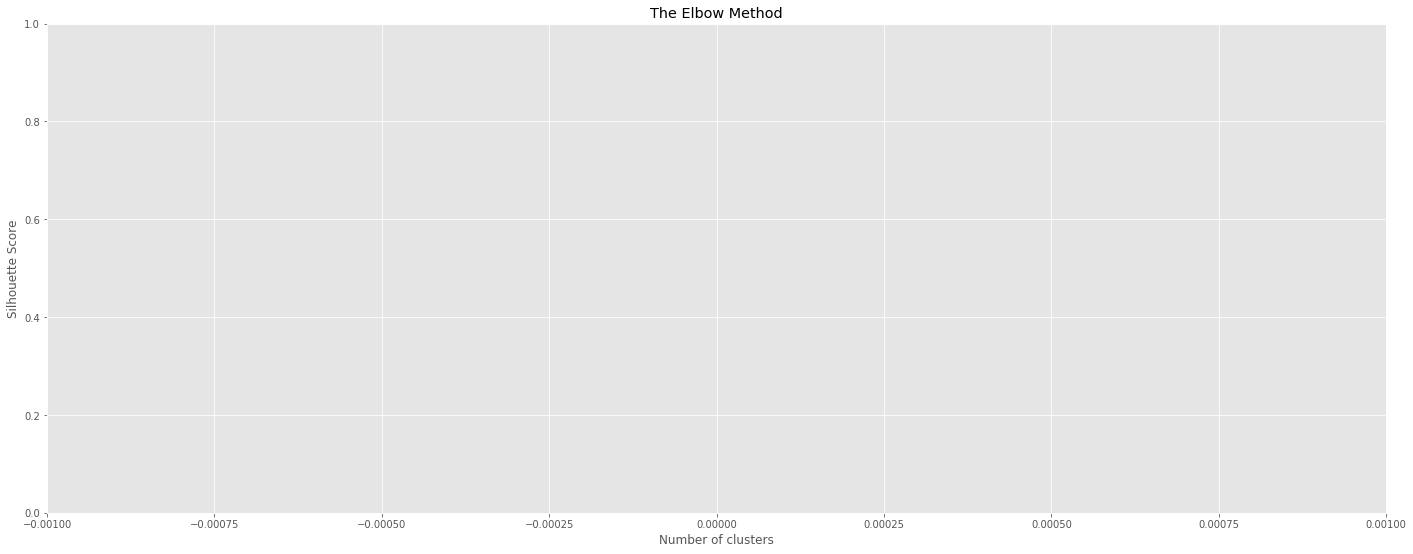

In [66]:
plt.figure()
plt.ylabel('Silhouette Score')
plt.xlabel('Number of clusters')
plt.title('The Elbow Method')    

plt.xlim( np.amin(results_iterations), np.amax(results_iterations))
plt.ylim(np.amin(results_silhouettes), np.amax(results_silhouettes))
plt.plot(results_iterations, results_silhouettes)

plt.show()